In [49]:
import os
import cv2
import sys
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [50]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

In [52]:
csv_path = os.path.join("..", "datasets", "out.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 16000
val dataset size: 4000


In [53]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))

      else:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))

      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [54]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
dataset = APN_Dataset(df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 16000
validset size: 4000


In [55]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = False)

In [56]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 500
#batches in validloader : 125


In [57]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [58]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [59]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [60]:
def create_embeddings(model, dataloader, batch_size, ds) :
    model.eval()
    out = pd.DataFrame(columns=["Anchor", "Positive", "Negative", "A_emb", "P_emb", "N_emb"])
    i=0
    with torch.no_grad():
        
        for A, P, N in tqdm(dataloader, desc="create embeddings..."):
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            
            for j in range (batch_size):
                out.loc[i] = [
                ds.iloc[i]["Anchor"], 
                ds.iloc[i]["Positive"], 
                ds.iloc[i]["Negative"],
                A_embs[j].cpu(),
                P_embs[j].cpu(),
                N_embs[j].cpu()
                ] 
            i = i+1
                
    out.to_csv("prova.csv",index=False)
    return out

            


In [61]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)


In [62]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [63]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [64]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


train_df1, valid_df1 = train_test_split(create_embeddings(model,dataloader, BATCH_SIZE,df), test_size=0.20, random_state=42)
train_df2 = shm.semi_hard_mining(train_df1,model,0.2) 

valid_df2 = shm.semi_hard_mining(valid_df1,model,0.2)

trainset1 = APN_Dataset(train_df2)
validset1 = APN_Dataset(valid_df2)


trainloader_semi_hard= DataLoader(trainset1, batch_size = BATCH_SIZE, shuffle = True)
validloader_semi_hard = DataLoader(validset1, batch_size = BATCH_SIZE)
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader_semi_hard, optimizer, criterion)
  valid_loss = eval_fn(model, validloader_semi_hard, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model validating...:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\acali\PycharmProjects\project-detective\.venv\lib\site-packages\timm\layers\conv2d_same.py:27: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)
model validating...: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


successful weights saving...
epochs: 1, train_loss: 0.29336581627527875, valid_loss: 0.8145073056221008


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


successful weights saving...
epochs: 2, train_loss: 0.12821856141090393, valid_loss: 0.6183963418006897


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


successful weights saving...
epochs: 3, train_loss: 0.029028385877609253, valid_loss: 0.45308172702789307


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


successful weights saving...
epochs: 4, train_loss: 0.07442168891429901, valid_loss: 0.36684244871139526


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


successful weights saving...
epochs: 5, train_loss: 0.013680517673492432, valid_loss: 0.3356759250164032


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


successful weights saving...
epochs: 6, train_loss: 0.0, valid_loss: 0.3203246593475342


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


successful weights saving...
epochs: 7, train_loss: 0.0, valid_loss: 0.3016757369041443


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


epochs: 8, train_loss: 0.0021736820538838706, valid_loss: 0.30319318175315857


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


successful weights saving...
epochs: 9, train_loss: 0.020282859603563946, valid_loss: 0.2999272346496582


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


epochs: 10, train_loss: 0.0016105820735295613, valid_loss: 0.3396192789077759


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


epochs: 11, train_loss: 0.019648894667625427, valid_loss: 0.38075530529022217


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


epochs: 12, train_loss: 0.0, valid_loss: 0.4323481619358063


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


epochs: 13, train_loss: 0.025095919768015545, valid_loss: 0.4850235879421234


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


epochs: 14, train_loss: 0.039650494853655495, valid_loss: 0.48923903703689575


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


epochs: 15, train_loss: 0.0, valid_loss: 0.5104127526283264


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


epochs: 16, train_loss: 0.0, valid_loss: 0.5781770944595337


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


epochs: 17, train_loss: 0.0, valid_loss: 0.6626811027526855


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


epochs: 18, train_loss: 0.008379379908243815, valid_loss: 0.6318261027336121


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


epochs: 19, train_loss: 0.0031534135341644287, valid_loss: 0.652799129486084


model validating...: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


epochs: 20, train_loss: 0.0, valid_loss: 0.6705072522163391


model validating...: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


epochs: 21, train_loss: 0.0, valid_loss: 0.667233943939209


model validating...: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


epochs: 22, train_loss: 0.005643710494041443, valid_loss: 0.6692485809326172


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


epochs: 23, train_loss: 0.0, valid_loss: 0.6728543639183044


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


epochs: 24, train_loss: 0.007667164007822673, valid_loss: 0.7045180797576904


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


epochs: 25, train_loss: 0.01069470246632894, valid_loss: 0.6937628388404846


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


epochs: 26, train_loss: 0.0, valid_loss: 0.7144288420677185


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


epochs: 27, train_loss: 0.014383897185325623, valid_loss: 0.6775565147399902


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


epochs: 28, train_loss: 0.014985496799151102, valid_loss: 0.6589036583900452


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


epochs: 29, train_loss: 0.014364764094352722, valid_loss: 0.6102191209793091


model validating...: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

epochs: 30, train_loss: 0.028653437892595928, valid_loss: 0.6057796478271484


<function matplotlib.pyplot.show(close=None, block=None)>

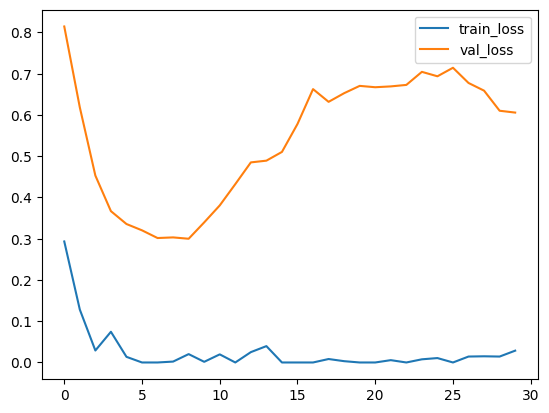

In [65]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [70]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if str(i).startswith("coco"):
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [71]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 20000/20000 [09:42<00:00, 34.31it/s]


In [72]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/train2017/img077313.jpg,-0.204685,-0.191130,0.098484,-0.204370,0.065292,0.363037,0.083017,-0.032329,-0.031222,...,0.006152,0.147181,-0.429884,-0.011791,0.346403,0.123832,-0.070861,0.091341,-0.247292,0.134676
1,coco/coco2017/train2017/img081457.jpg,-0.142372,-0.118361,0.101852,0.042731,-0.135906,0.285048,0.117334,0.144155,-0.004581,...,-0.031505,-0.075820,0.138407,-0.316204,-0.157027,0.168813,0.051183,0.230990,-0.035936,0.170828
2,tt-ffhq/ffhq_k300_p1.0_fid9.6/img025149.jpg,-0.063383,0.106869,-0.230683,-0.165608,-0.281022,-0.114101,-0.163643,-0.212839,0.321815,...,-0.000032,0.237489,-0.263898,-0.220716,0.020770,0.211617,-0.097189,0.195398,0.077921,-0.196372
3,coco/coco2017/train2017/img062087.jpg,0.082885,0.237379,-0.328033,-0.143369,-0.323850,0.184616,0.141662,-0.247401,-0.182348,...,-0.149945,0.270419,0.439697,0.538683,-0.534097,-0.419789,0.240917,-0.153351,0.095007,-0.098537
4,tt-ffhq/ffhq_k300_p1.0_fid9.6/img003641.jpg,-0.109068,0.011639,-0.016269,0.125619,-0.250014,0.163737,0.085684,-0.109934,0.249093,...,0.015115,-0.192301,0.160720,-0.035872,0.112956,0.038147,0.155821,0.325280,-0.059061,0.114510


In [73]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [ ]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

In [74]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [ ]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [81]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "timing_transformer")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(20000, 3)

In [82]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)

    if mode == "rgb":
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 0it [00:00, ?it/s]


KeyError: 'fake'

In [ ]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

In [83]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 0it [00:00, ?it/s]


KeyError: 'real'

In [ ]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

In [ ]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(valid_df))
print(y_true.shape)

temp = np.array(["real"] * len(valid_df))
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

In [ ]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

In [ ]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)